(original)

# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 


## Load packages

In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

## Plots setup

In [3]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

## Load dataset

TODO: INSERT NEW DF WITH 200 X_test:

In [100]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
df_for_random = df.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF

## Mergesort ranker

In [5]:
# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

In [6]:
# dfs_test_use =  X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})


In [7]:
# MERGESORT HERUNDER PÅ BIG 
X_test_y_test_FULL = pd.DataFrame()
dfs_test_use_temp=dfs_test_use.copy()

for i in range(200):
    dfs_test_use_temp[i]= dfs_test_use_temp[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use_temp[i]= dfs_test_use_temp[i].reset_index()

    data_value_counts_gen = []
    
    for j in range(1,len(dfs_test_use_temp[i])+1):
        data_value_counts_gen.append(np.array([dfs_test_use_temp[i]["4"][:j].value_counts(normalize=True)]))
    dfs_test_use_temp[i]["value_counts_col_GENDER"] = data_value_counts_gen

    data_entropy = []
    for k in range(len(dfs_test_use_temp[i])):
        data_entropy.append(-(dfs_test_use_temp[i]["value_counts_col_GENDER"][k]*np.log2(dfs_test_use_temp[i]["value_counts_col_GENDER"][k])).sum())
   
  
    dfs_test_use_temp[i]["entropy_col_GENDER"] = data_entropy

    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use_temp[i])


X_test_y_test_FULL.index.names = ['INDEXES']


df_sort_BIG =X_test_y_test_FULL

In [9]:
#Mean gender entropy
df_sort_BIG_mean =  df_sort_BIG.groupby('INDEXES').mean()
#df_sort_BIG_mean["intr_col_entropy"] = df_sort_BIG_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
df_sort_BIG_std =  df_sort_BIG.groupby('INDEXES').std()/np.sqrt(200)
#df_sort_BIG_std["incr_col_entropy"] = df_sort_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_sort_BIG_mean["incr_half_std"] = 0.5*df_sort_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_sort_BIG_mean["lower_std"] = df_sort_BIG_mean["entropy_col_GENDER"] - df_sort_BIG_mean["incr_half_std"]
df_sort_BIG_mean["upper_std"] = df_sort_BIG_mean["entropy_col_GENDER"] + df_sort_BIG_mean["incr_half_std"]


In [9]:
df_sort_BIG_mean

,index,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,entropy_col_GENDER,incr_col_entropy,incr_half_std,lower_std,upper_std
INDEXES,,,,,,,,,,,,,,,,,,,,,,,,,,
0,409418.135,7014.755,83.050,98.630,95.035,97.505000,0.650,0.0,0.000,0.010,0.195,0.320,0.425,0.050,0.990,0.0,0.000,0.010,0.990,0.010,97.633333,0.000000,0.000000,0.000000,0.000000,0.000000
1,409661.005,6354.085,87.710,95.455,93.095,95.333333,0.250,0.0,0.000,0.045,0.300,0.035,0.445,0.175,0.950,0.0,0.000,0.050,0.950,0.050,96.348333,0.580000,0.290000,0.008747,0.281253,0.298747
2,409545.750,5463.810,87.970,93.610,91.795,93.988333,0.155,0.0,0.000,0.120,0.380,0.130,0.180,0.190,0.875,0.0,0.000,0.125,0.870,0.130,96.215000,0.739228,0.439743,0.010130,0.429613,0.449872
3,409580.375,6322.270,87.815,91.660,90.530,92.950000,0.165,0.0,0.000,0.100,0.390,0.215,0.085,0.210,0.865,0.0,0.000,0.135,0.860,0.140,96.703333,0.763654,0.520721,0.010258,0.510463,0.530978
4,409435.265,6784.360,86.715,91.185,90.135,92.186667,0.170,0.0,0.000,0.080,0.420,0.320,0.050,0.130,0.875,0.0,0.000,0.125,0.880,0.120,95.346667,0.744615,0.565499,0.010239,0.555260,0.575739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,409575.175,6736.890,46.795,32.785,36.730,36.918333,0.330,0.0,0.515,0.280,0.205,0.000,0.000,0.000,0.595,0.0,0.005,0.400,0.290,0.710,21.431667,0.974650,0.959394,0.000346,0.959048,0.959741
4092,409729.180,6617.330,47.925,33.585,36.575,36.475000,0.320,0.0,0.575,0.325,0.100,0.000,0.000,0.000,0.630,0.0,0.010,0.360,0.300,0.700,17.973333,0.974638,0.959398,0.000346,0.959051,0.959744
4093,409727.820,6197.615,48.350,33.825,34.695,35.766667,0.350,0.0,0.600,0.360,0.040,0.000,0.000,0.000,0.655,0.0,0.010,0.335,0.275,0.725,15.211667,0.974632,0.959402,0.000346,0.959055,0.959748


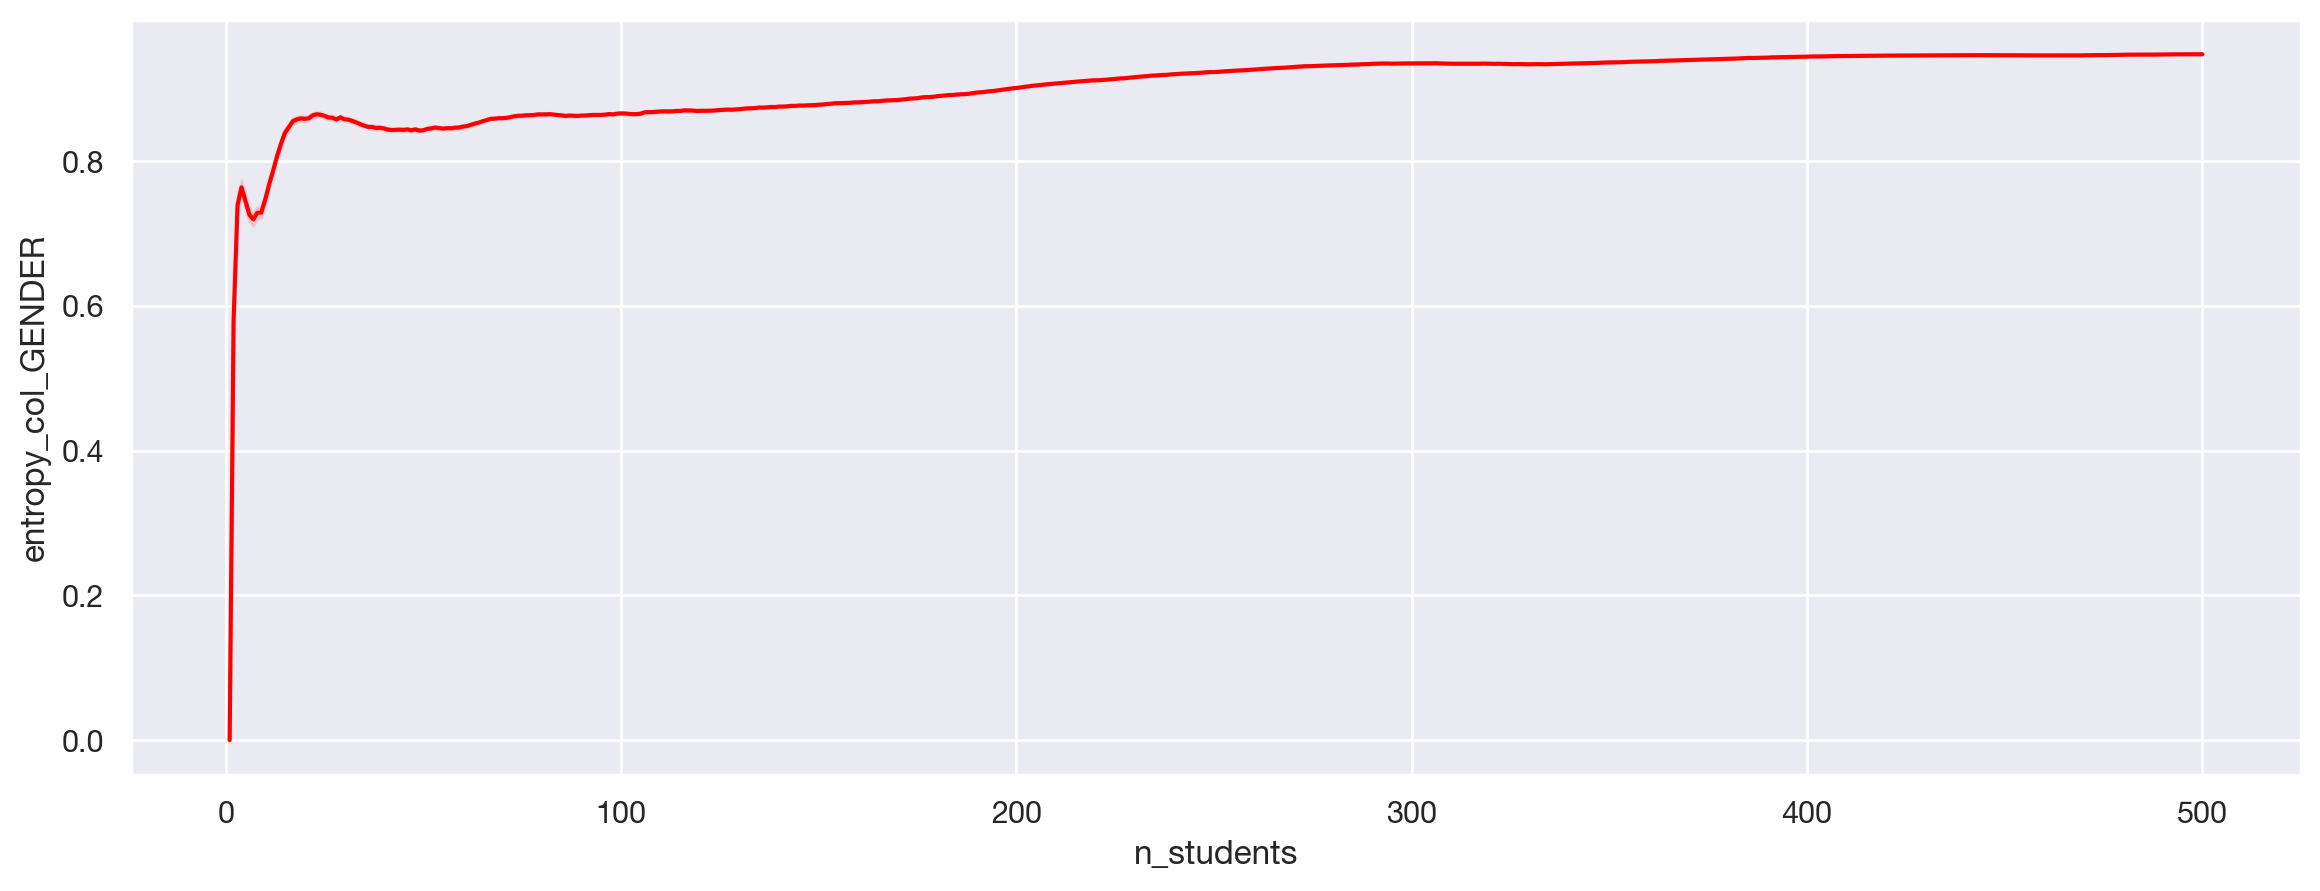

In [77]:
#n students cumsum
df_sort_BIG_mean["n_students"] = range(1,len(df_sort_BIG_mean)+1)

sns.lineplot(data=df_sort_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[0:500], alpha=0.1, color="red")
plt.show()

## Gendersort ranker

In [11]:
#Gendersort all - GAB

# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

X_test_y_test_GENDER = pd.DataFrame()


 
def gender_mergesort_BIG(df):
    
    dfs_test_use = df #= X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    
    #gender_df_BIG_func = pd.DataFrame()
    X_test_y_test_GENDER = pd.DataFrame()
 
    for i in range(len(dfs_test_use)):
        sorted_with_gender = pd.DataFrame()
        FEMALES = pd.DataFrame()
        MALES = pd.DataFrame()
        fem = dfs_test_use[i][dfs_test_use[i]['4'] != 0] #'4' = Gender_bins
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]

        fem = fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index() #'3' = HI_AVG_GPA
        mal = mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()

        FEMALES = FEMALES.append(fem)
        MALES=MALES.append(mal)
        
        
        FEMALES.index.names = ['INDEXES']
        MALES.index.names = ['INDEXES']

        if FEMALES['3'].max() > MALES['3'].max():
            sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
        else: 
            sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()
            
        
        #gender_df_BIG_func=gender_df_BIG_func.append(sorted_with_gender)
        #print(len(gender_df_BIG_func), "BIG")
        

        data_value_counts_gen = []

        for k in range(1,len(sorted_with_gender)+1):
            data_value_counts_gen.append(np.array([sorted_with_gender["4"][:k].value_counts(normalize=True)]))
        sorted_with_gender["value_counts_col_GENDER"] = data_value_counts_gen

        data_entropy = []
        for l in range(len(sorted_with_gender)):
            data_entropy.append(-(sorted_with_gender["value_counts_col_GENDER"].iloc[l]*np.log2(sorted_with_gender["value_counts_col_GENDER"].iloc[l])).sum())
        sorted_with_gender["entropy_col_GENDER"] = data_entropy
        
        #append each i df to big df
        X_test_y_test_GENDER = X_test_y_test_GENDER.append(sorted_with_gender)
        #print(len(X_test_y_test_GENDER))
        
        
    return X_test_y_test_GENDER.reset_index()
        

In [12]:
gender_df_BIG = gender_mergesort_BIG(dfs_test_use)


In [13]:
#GENDER ranker

#CMA gender entropy
gender_df_BIG_mean =  gender_df_BIG.groupby('INDEXES').mean()
#gender_df_BIG_mean["incr_col_entropy"] = gender_df_BIG_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
gender_df_BIG_std =  gender_df_BIG.groupby('INDEXES').std()/np.sqrt(200)
#gender_df_BIG_std["incr_col_entropy"] = gender_df_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
gender_df_BIG_mean["incr_half_std"] = 0.5*gender_df_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
gender_df_BIG_mean["lower_std"] = gender_df_BIG_mean["entropy_col_GENDER"] - gender_df_BIG_mean["incr_half_std"]
gender_df_BIG_mean["upper_std"] = gender_df_BIG_mean["entropy_col_GENDER"] + gender_df_BIG_mean["incr_half_std"]


#nstudents
gender_df_BIG_mean["n_students"] = range(1,len(gender_df_BIG_mean)+1)


In [23]:
gender_df_BIG_mean

,index,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,entropy_col_GENDER,incr_col_entropy,incr_half_std,lower_std,upper_std,n_students
INDEXES,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,409482.865000,6394.977500,84.637500,97.015000,92.980000,95.911667,0.5,0.0,0.000000,0.022500,0.277500,0.2000,0.4125,0.0875,0.977500,0.0,0.0,0.022500,0.9600,0.0400,96.825833,0.500000,0.500000,0.017700,0.482300,0.517700,1
1,409600.992500,6203.270000,85.852500,92.887500,89.480000,92.818333,0.5,0.0,0.000000,0.077500,0.422500,0.1450,0.2050,0.1500,0.917500,0.0,0.0,0.082500,0.8525,0.1475,96.704167,0.959148,0.729574,0.009573,0.720001,0.739147,2
2,409422.692500,7058.092500,83.097500,88.577500,89.125000,91.177500,0.5,0.0,0.000000,0.052500,0.492500,0.1750,0.1150,0.1650,0.915000,0.0,0.0,0.085000,0.8950,0.1050,96.073333,0.985475,0.814874,0.006553,0.808321,0.821428,3
3,409626.807500,7754.730000,81.910000,86.360000,88.680000,90.283333,0.5,0.0,0.000000,0.040000,0.447500,0.2200,0.1500,0.1425,0.922500,0.0,0.0,0.077500,0.9400,0.0600,94.632500,0.992614,0.859309,0.004980,0.854329,0.864290,4
4,409650.952500,7671.382500,82.565000,84.602500,89.732500,89.553333,0.5,0.0,0.000000,0.042500,0.407500,0.2075,0.2050,0.1375,0.912500,0.0,0.0,0.087500,0.9625,0.0375,93.799167,0.995538,0.886555,0.004016,0.882539,0.890571,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,402126.750000,4596.500000,52.500000,28.750000,35.500000,36.333333,0.0,0.0,0.250000,0.500000,0.250000,0.0000,0.0000,0.0000,0.750000,0.0,0.0,0.250000,0.7500,0.2500,22.250000,0.966953,0.996229,0.000020,0.996209,0.996249,2483
2483,449260.000000,8486.333333,43.000000,33.666667,35.333333,36.555556,0.0,0.0,0.666667,0.333333,0.000000,0.0000,0.0000,0.0000,0.333333,0.0,0.0,0.666667,0.0000,1.0000,19.000000,0.966808,0.996217,0.000020,0.996197,0.996237,2484
2484,450133.000000,7203.333333,49.000000,26.333333,38.666667,35.666667,0.0,0.0,0.333333,0.333333,0.333333,0.0000,0.0000,0.0000,1.000000,0.0,0.0,0.000000,1.0000,0.0000,16.444444,0.966748,0.996205,0.000020,0.996185,0.996225,2485


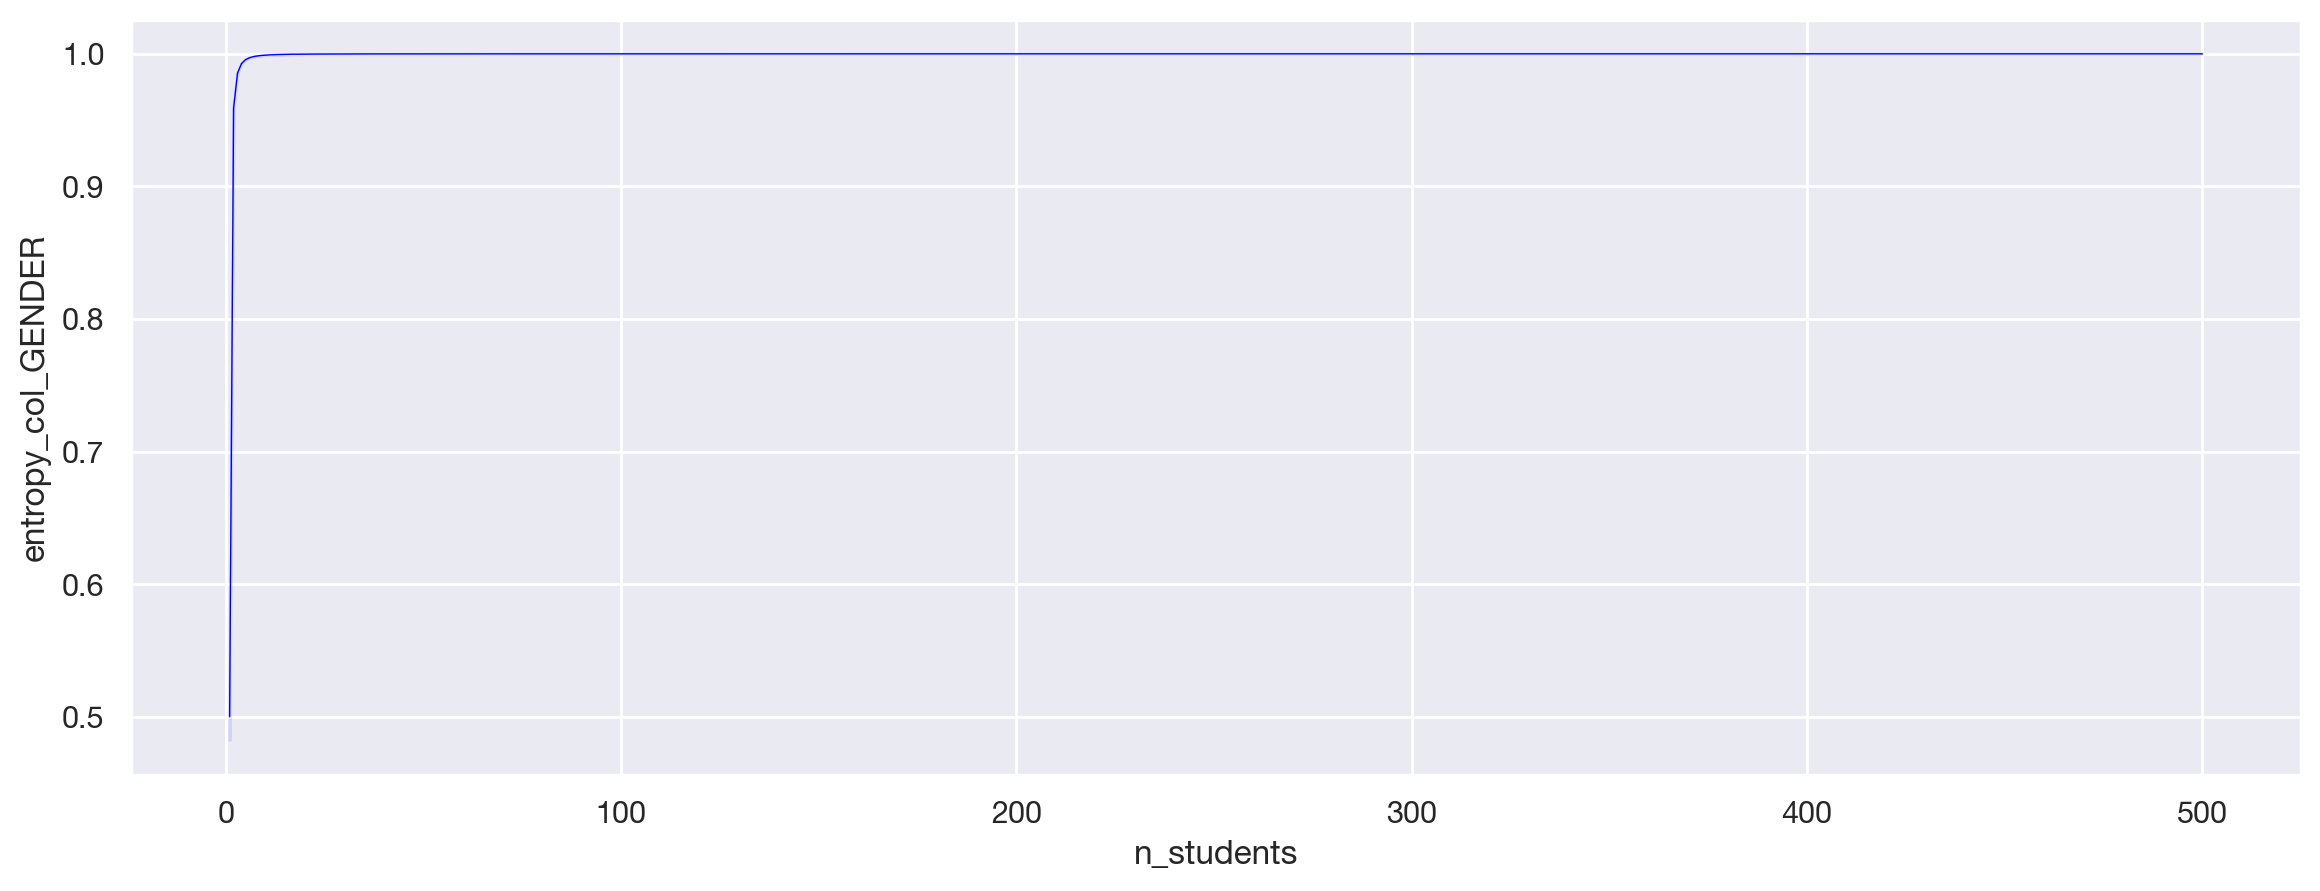

In [67]:
## PLOT

#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")
# sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")

# big gender df
#sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.1)
sns.lineplot(data=gender_df_BIG_mean[0:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[0:500], alpha=0.1, color="blue")
plt.show()

## Plain XGBoost 

In [34]:
df_PLAIN_TWO_NY = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
indexs = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()
#apply new column of cumsum+1

#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_PLAIN_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_PLAIN_TWO_NY_use[df_PLAIN_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]

In [35]:
df_PLAIN_TWO_NY_use["Gender_bins"][2]#[:500].value_counts()
GUDF = pd.read_csv('GUDF.csv')

Splitte_PLAIN = np.array_split(df_PLAIN_TWO_NY_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op
GUDF['Idx'] = GUDF['Unnamed: 0'] 


In [36]:
Splitte_PLAIN[1]["Unnamed: 0"].max()

499

In [37]:
pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [38]:
PLAIN_USE_VALUE_COUNTS.iloc[[500,510, 1000,1010]]

,value_counts_col_GENDER
500,[[]]
510,[[1.0]]
1000,[[]]
1010,"[[0.8, 0.2]]"


In [39]:
#append value counts to dataframe
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()

In [40]:
df_PLAIN_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER
df_PLAIN_TWO_NY_use

,index,Unnamed: 0,Idx,Gender_bins,Preds,value_counts_col_GENDER
0,0,0,7490,1,92.565254,[[]]
1,1,1,12018,1,92.565254,[[1.0]]
2,2,2,11864,1,92.565254,[[1.0]]
3,3,3,12016,0,92.565254,[[1.0]]
4,4,4,1089,0,92.477142,"[[0.75, 0.25]]"
...,...,...,...,...,...,...
99995,815599,495,12144,0,84.307159,"[[0.6383838383838384, 0.3616161616161616]]"
99996,815600,496,169,0,84.275749,"[[0.6391129032258065, 0.36088709677419356]]"
99997,815601,497,9616,0,84.275749,"[[0.6398390342052314, 0.36016096579476864]]"
99998,815602,498,11648,0,84.181122,"[[0.6405622489959839, 0.35943775100401604]]"


In [41]:
df_PLAIN_TWO_NY_use

,index,Unnamed: 0,Idx,Gender_bins,Preds,value_counts_col_GENDER
0,0,0,7490,1,92.565254,[[]]
1,1,1,12018,1,92.565254,[[1.0]]
2,2,2,11864,1,92.565254,[[1.0]]
3,3,3,12016,0,92.565254,[[1.0]]
4,4,4,1089,0,92.477142,"[[0.75, 0.25]]"
...,...,...,...,...,...,...
99995,815599,495,12144,0,84.307159,"[[0.6383838383838384, 0.3616161616161616]]"
99996,815600,496,169,0,84.275749,"[[0.6391129032258065, 0.36088709677419356]]"
99997,815601,497,9616,0,84.275749,"[[0.6398390342052314, 0.36016096579476864]]"
99998,815602,498,11648,0,84.181122,"[[0.6405622489959839, 0.35943775100401604]]"


In [42]:
#get entropy of valuecounts for all rows
df_PLAIN_TWO_NY_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_PLAIN_TWO_NY_entropy_GENDER.append(-(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_PLAIN_TWO_NY_use["entropy_col_GENDER"] = df_PLAIN_TWO_NY_entropy_GENDER

In [43]:
#create entropy mean df and entropy std df
df_PLAIN_TWO_NY_ENTROPY = df_PLAIN_TWO_NY_use
df_PLAIN_TWO_NY_ENTROPY_std = df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_PLAIN_TWO_NY_ENTROPY_mean =  df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').mean()


In [44]:
df_PLAIN_TWO_NY_ENTROPY_std

,index,Idx,Gender_bins,Preds,entropy_col_GENDER
Unnamed: 0,,,,,
0,16763.602477,208.021033,0.011067,0.030358,0.000000
1,16763.602477,232.239893,0.011067,0.030464,0.000000
2,16763.602477,232.084270,0.013891,0.030531,0.012093
3,16763.602477,208.647990,0.013028,0.030665,0.014841
4,16763.602477,225.152648,0.015450,0.030521,0.016828
...,...,...,...,...,...
495,16763.602477,249.954453,0.033459,0.026529,0.001112
496,16763.602477,262.281772,0.033580,0.026592,0.001121
497,16763.602477,259.172926,0.034225,0.026615,0.001126


### OBS: CMA entropy mean and CMA standard error

In [45]:
#df_PLAIN_TWO_NY_ENTROPY_mean["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_PLAIN_TWO_NY_ENTROPY_std["CMA_gender_entropy"] = df_PLAIN_TWO_NY_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_PLAIN_TWO_NY_ENTROPY_mean["n_students"] = range(1,len(df_PLAIN_TWO_NY_ENTROPY_mean)+1)

# df_PLAIN_TWO_NY_ENTROPY_std[50:150]


df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"] = .5*df_PLAIN_TWO_NY_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_PLAIN_TWO_NY_ENTROPY_mean["lower_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] - df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]
df_PLAIN_TWO_NY_ENTROPY_mean["upper_std"] = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"] + df_PLAIN_TWO_NY_ENTROPY_mean["incr_half_std"]






In [46]:
## MEAN Entropy
entr_plain = df_PLAIN_TWO_NY_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_plain: ", entr_plain)

entr_plain:  0.9447026137942097


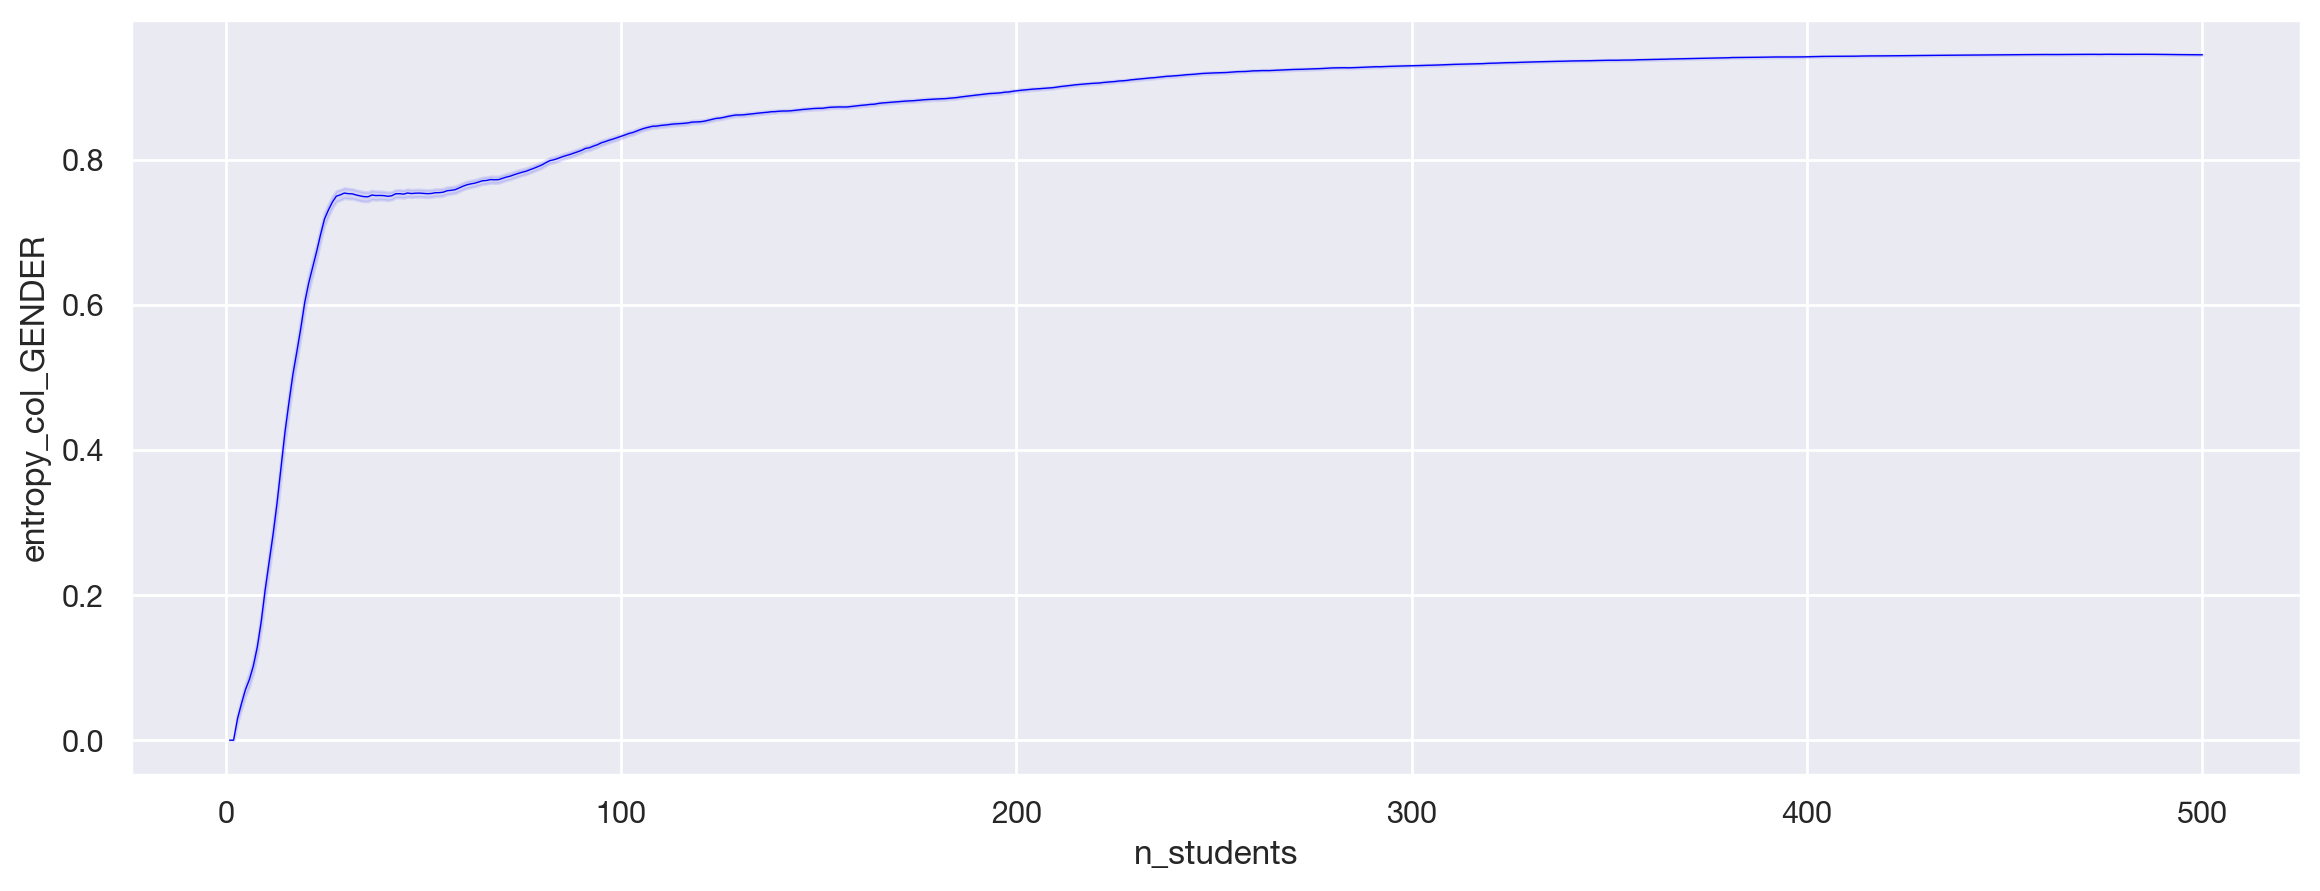

In [68]:
#sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="Unnamed: 0", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="blue", ci="sd", linewidth=0.5)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[:500], alpha=0.1, color="blue")


## XGBoost w/o sensitive attributes

In [48]:
df_wo = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]
df_wo_use = df_wo_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_wo_use["Unnamed: 0"].unique():
    stds.append(df_wo_use[df_wo_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]

#split df
Splitte_PLAIN = np.array_split(df_wo_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op


In [49]:
pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


In [50]:
#append value counts to dataframe
df_wo_use = df_wo_use.reset_index()

df_wo_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


In [51]:
#get entropy of valuecounts for all rows
df_wo_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_wo_entropy_GENDER.append(-(df_wo_use["value_counts_col_GENDER"][i]*np.log2(df_wo_use["value_counts_col_GENDER"][i])).sum())    

df_wo_use["entropy_col_GENDER"] = df_wo_entropy_GENDER

#create entropy mean df and entropy std df
df_wo_ENTROPY = df_wo_use
df_wo_ENTROPY_std = df_wo_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_wo_ENTROPY_mean =  df_wo_ENTROPY.groupby('Unnamed: 0').mean()


In [52]:
#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
#df_wo_ENTROPY_mean["CMA_gender_entropy"] = df_wo_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_wo_ENTROPY_std["CMA_gender_entropy"] = df_wo_ENTROPY_std.entropy_col_GENDER.expanding().mean()/np.sqrt(200)

df_wo_ENTROPY_mean["n_students"] = range(1,len(df_wo_ENTROPY_mean)+1)


#create std error
df_wo_ENTROPY_mean["incr_half_std"] = .5*df_wo_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_wo_ENTROPY_mean["lower_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] - df_wo_ENTROPY_mean["incr_half_std"]
df_wo_ENTROPY_mean["upper_std"] = df_wo_ENTROPY_mean["entropy_col_GENDER"] + df_wo_ENTROPY_mean["incr_half_std"]




In [53]:
## MEAN Entropy
entr_wo = df_wo_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_wo: ", entr_wo)

entr_wo:  0.9474517528779118


In [ ]:

#df_WO_ENTROPY = df_wo_use
#df_WO_ENTROPY_std = df_WO_ENTROPY.groupby('Unnamed: 0').std()
#df_WO_ENTROPY_mean =  df_WO_ENTROPY.groupby('Unnamed: 0').mean()
# df_WO_ENTROPY_mean = df_WO_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
#df_WO_ENTROPY_mean["ENTROPY_KAT"] = df_WO_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
# sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")


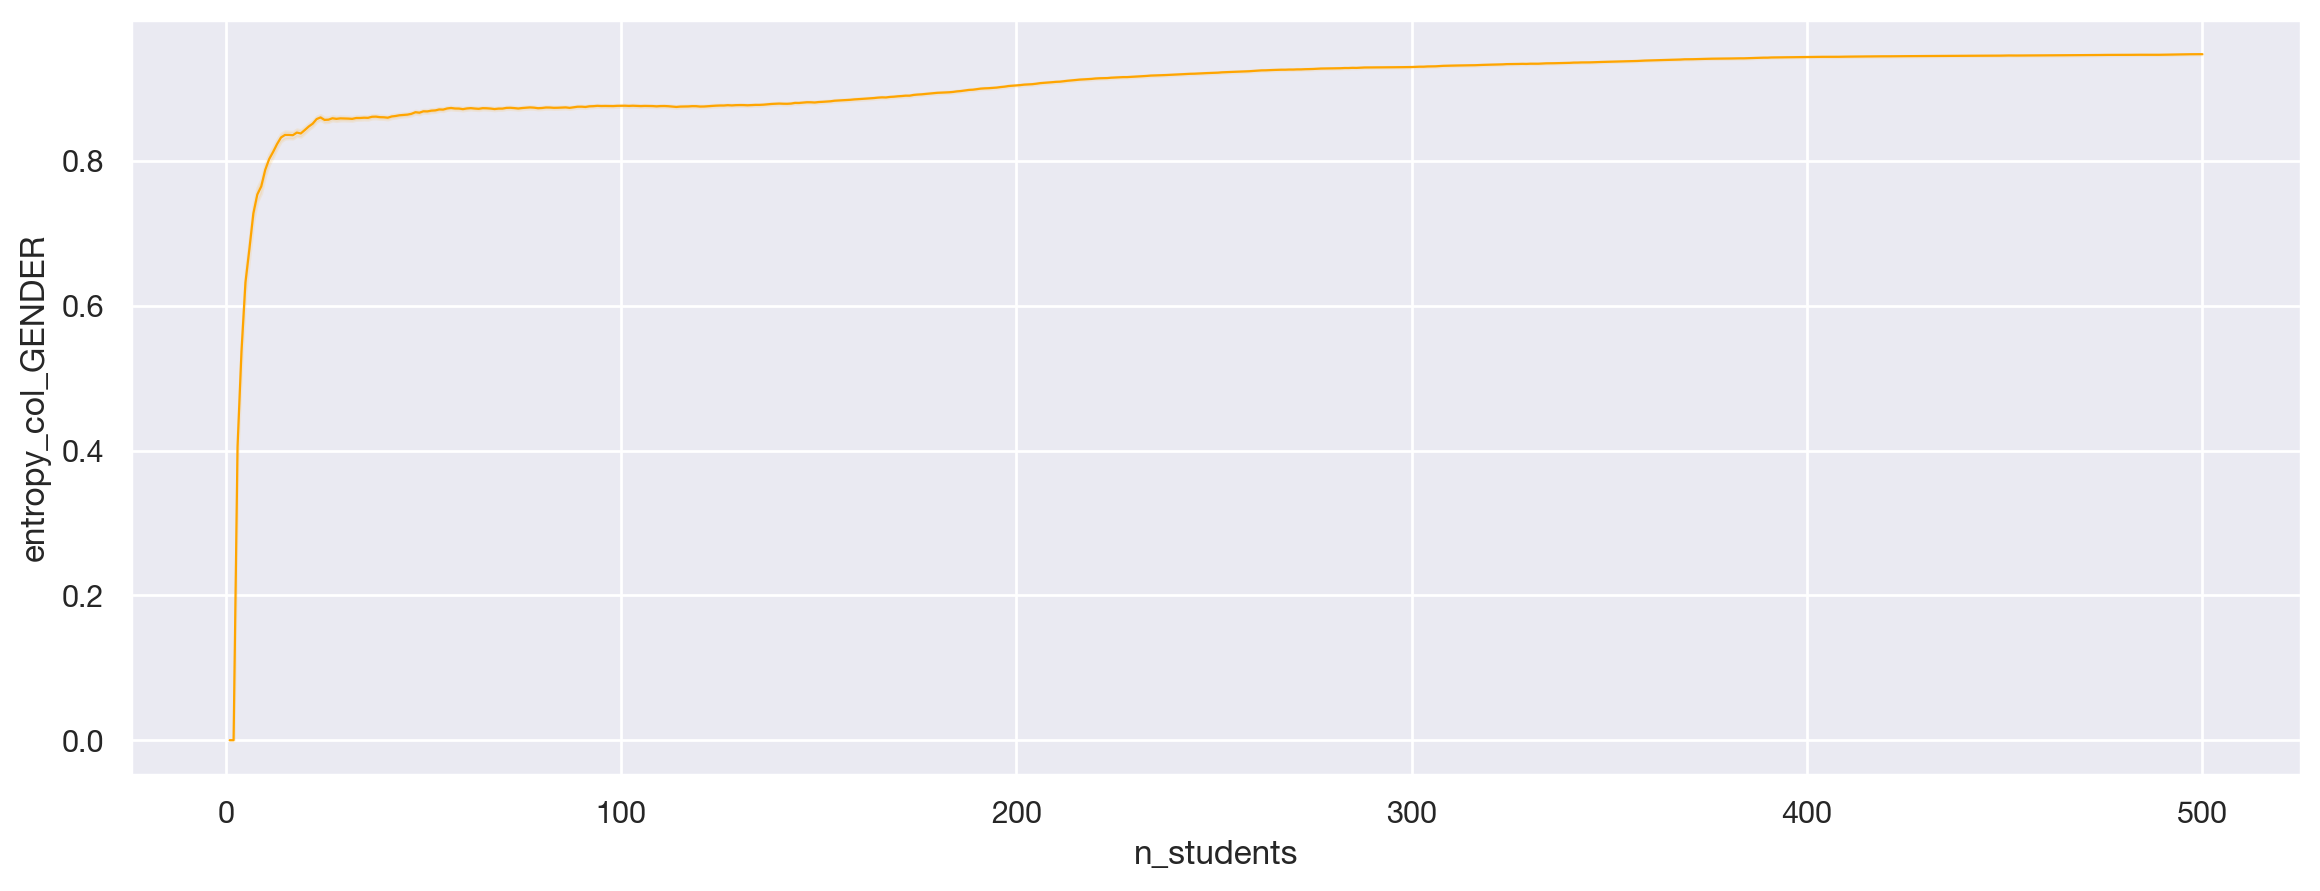

In [70]:
sns.lineplot(data=df_wo_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd", linewidth=0.8)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[:500], alpha=0.1, color="orange")


## Fairness enhanced Ranker 

In [55]:
df_FAIR_TWO_NY = pd.read_csv('re_ranked_199_NY.csv')
indexs = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_FAIR_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_FAIR_TWO_NY_use[df_FAIR_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]


#split df
Splitte_PLAIN = np.array_split(df_FAIR_TWO_NY_use, 200) #splitte plain er df_PLAIN_TWO_NY_use bare splittet op


In [89]:
## Create entropy

pd.options.mode.chained_assignment = None 
# df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
PLAIN_USE_VALUE_COUNTS = pd.DataFrame(columns=['value_counts_col_GENDER'])
i = 0
while i < 200: #iterate over 200 dfs
    idx = 0
    while idx <= Splitte_PLAIN[i]["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        #append each value to column in empty dataframe
        PLAIN_USE_VALUE_COUNTS = PLAIN_USE_VALUE_COUNTS.append({'value_counts_col_GENDER' : np.array([Splitte_PLAIN[i]["Gender_bins"][:idx].value_counts(normalize=True)])}, ignore_index=True)     
        idx = idx+1 
    i = i+1


#append value counts to dataframe
df_FAIR_TWO_NY_use = df_wo_use.reset_index()

df_FAIR_TWO_NY_use["value_counts_col_GENDER"] = PLAIN_USE_VALUE_COUNTS.value_counts_col_GENDER


#get entropy of valuecounts for all rows
df_fair_entropy_GENDER = []
for i in range(len(df_PLAIN_TWO_NY_use)):
    df_fair_entropy_GENDER.append(-(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_FAIR_TWO_NY_use["entropy_col_GENDER"] = df_fair_entropy_GENDER

#create entropy mean df and entropy std df
df_fair_ENTROPY = df_FAIR_TWO_NY_use
df_fair_ENTROPY_std = df_fair_ENTROPY.groupby('Unnamed: 0').std()/np.sqrt(200)
df_fair_ENTROPY_mean =  df_fair_ENTROPY.groupby('Unnamed: 0').mean()


#expand means of df_wo_ENTROPY_mean and df_wo_ENTROPY_std
df_fair_ENTROPY_mean["CMA_gender_entropy"] = df_fair_ENTROPY_mean.entropy_col_GENDER.expanding().mean()

#df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

df_fair_ENTROPY_mean["n_students"] = range(1,len(df_fair_ENTROPY_mean)+1)


#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std"] = df_fair_ENTROPY_mean["entropy_col_GENDER"] + df_fair_ENTROPY_mean["incr_half_std"]


In [117]:
# SE for cum: 
df_fair_ENTROPY_std["CMA_gender_entropy"] = df_fair_ENTROPY_std.entropy_col_GENDER.expanding().mean()

#create std error to plot
df_fair_ENTROPY_mean["incr_half_std"] = .5*df_fair_ENTROPY_std["CMA_gender_entropy"] #0.5 of std to plot on both sides of mean
df_fair_ENTROPY_mean["lower_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] - df_fair_ENTROPY_mean["incr_half_std"]
df_fair_ENTROPY_mean["upper_std_cum"] = df_fair_ENTROPY_mean["CMA_gender_entropy"] + df_fair_ENTROPY_mean["incr_half_std"]


In [59]:
## MEAN Entropy
entr_fair = df_fair_ENTROPY_mean["entropy_col_GENDER"][499]
print("entr_fair: ", entr_fair)

entr_fair:  0.9673336121854237


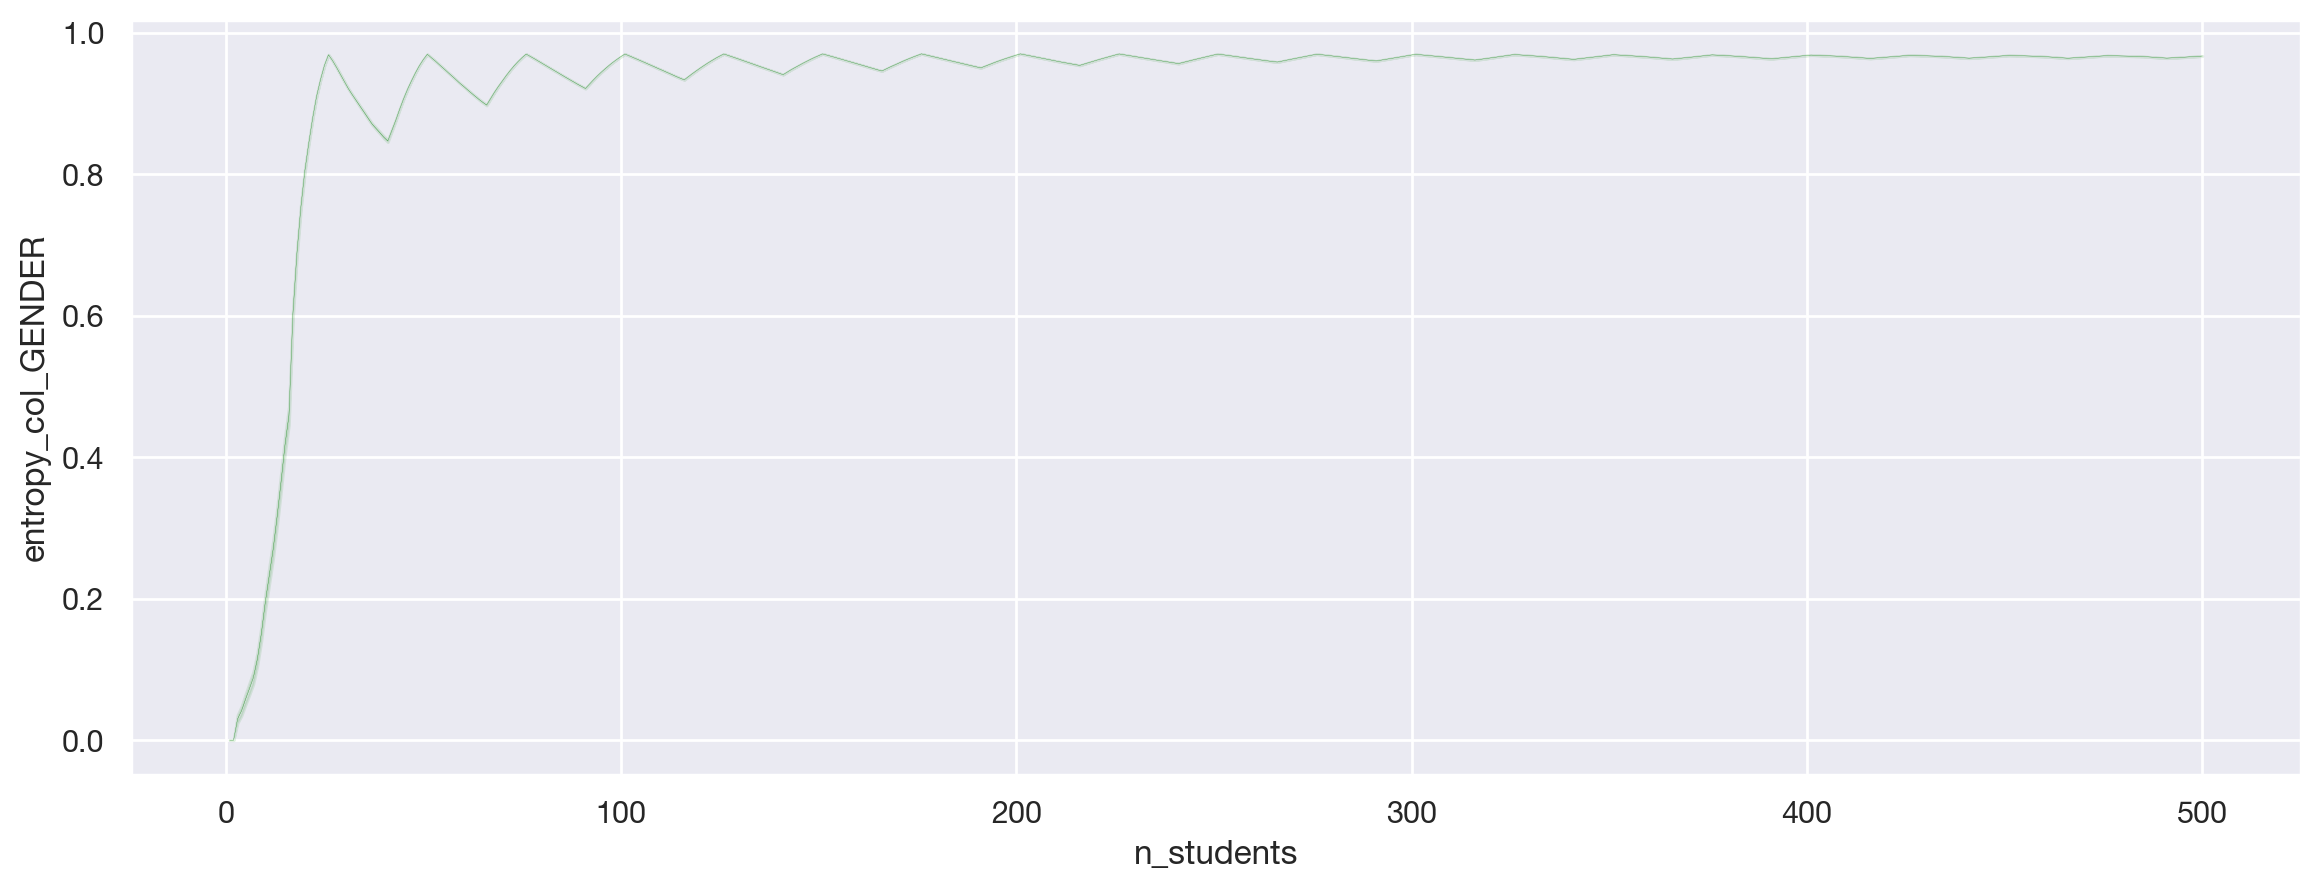

In [73]:
sns.lineplot(data=df_fair_ENTROPY_mean[:500], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd", linewidth=0.1)
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[:500], alpha=0.1, color="green")


In [84]:
df_fair_ENTROPY[:50]

,level_0,index,Unnamed: 0,Idx,Gender_bins,Preds,value_counts_col_GENDER,entropy_col_GENDER
0,0,0,0,2308,[1],93.107452,[[]],-0.000000
1,1,1,1,4900,[0],93.107452,[[1.0]],-0.000000
2,2,2,2,622,[1],93.107452,"[[0.5, 0.5]]",1.000000
3,3,3,3,10846,[1],93.107452,"[[0.6666666666666666, 0.3333333333333333]]",0.918296
4,4,4,4,12016,[0],93.107452,"[[0.75, 0.25]]",0.811278
5,5,5,5,10992,[1],93.107452,"[[0.6, 0.4]]",0.970951
6,6,6,6,7490,[1],93.107452,"[[0.5, 0.5]]",1.000000
7,7,7,7,8492,[1],93.107452,"[[0.5714285714285714, 0.42857142857142855]]",0.985228
8,8,8,8,1089,[0],93.107452,"[[0.625, 0.375]]",0.954434
9,9,9,9,8893,[0],93.107452,"[[0.5555555555555556, 0.4444444444444444]]",0.991076


In [88]:
pd.set_option("display.max_columns", None)
df_fair_ENTROPY_mean[20:60]


,level_0,index,Idx,Preds,entropy_col_GENDER,n_students,incr_half_std,lower_std,upper_std
Unnamed: 0,,,,,,,,,
20,49770.0,407572.0,7157.410,93.239073,0.843740,21,0.001922,0.841819,0.845662
21,49771.0,407573.0,7837.025,93.175590,0.879668,22,0.001233,0.878435,0.880902
22,49772.0,407574.0,7382.185,93.109893,0.910618,23,0.000709,0.909909,0.911327
23,49773.0,407575.0,7328.620,93.039213,0.934291,24,0.000293,0.933998,0.934584
24,49774.0,407576.0,7733.140,92.921061,0.954434,25,0.000000,0.954434,0.954434
25,49775.0,407577.0,7469.055,92.817341,0.969113,26,0.000247,0.968866,0.969360
26,49776.0,407578.0,7494.205,92.684241,0.961101,27,0.000163,0.960938,0.961264
27,49777.0,407579.0,7228.855,92.550034,0.951633,28,0.000243,0.951390,0.951876
28,49778.0,407580.0,7327.950,92.361484,0.941537,29,0.000299,0.941238,0.941835


### Observe cummulative standard error

In [29]:
df_fair_ENTROPY

,level_0,index,Unnamed: 0,Idx,Gender_bins,Preds,value_counts_col_GENDER,entropy_col_GENDER
0,0,0,0,2308,[1],93.107452,[[]],-0.000000
1,1,1,1,4900,[0],93.107452,[[1.0]],-0.000000
2,2,2,2,622,[1],93.107452,"[[0.5, 0.5]]",1.000000
3,3,3,3,10846,[1],93.107452,"[[0.6666666666666666, 0.3333333333333333]]",0.918296
4,4,4,4,12016,[0],93.107452,"[[0.75, 0.25]]",0.811278
...,...,...,...,...,...,...,...,...
99995,99995,815599,495,6778,[1],83.707405,"[[0.6121212121212121, 0.3878787878787879]]",0.963417
99996,99996,815600,496,2976,[1],83.707405,"[[0.6108870967741935, 0.38911290322580644]]",0.964225
99997,99997,815601,497,5943,[0],83.707405,"[[0.6096579476861167, 0.3903420523138833]]",0.965020
99998,99998,815602,498,8919,[0],83.707405,"[[0.608433734939759, 0.39156626506024095]]",0.965803


In [36]:
(0.013495+0.012093)/4

0.006397

In [30]:
df_fair_ENTROPY_std

,level_0,index,Idx,Preds,entropy_col_GENDER,CMA_gender_entropy
Unnamed: 0,,,,,,
0,2046.338193,16763.602477,228.438716,0.029173,0.000000,0.000000
1,2046.338193,16763.602477,235.121518,0.029173,0.000000,0.000000
2,2046.338193,16763.602477,239.217772,0.029173,0.012093,0.004031
3,2046.338193,16763.602477,216.519244,0.029173,0.013495,0.006397
4,2046.338193,16763.602477,229.914370,0.029173,0.015535,0.008224
...,...,...,...,...,...,...
495,2046.338193,16763.602477,255.080350,0.051410,0.000238,0.001000
496,2046.338193,16763.602477,240.233314,0.050698,0.000258,0.000999
497,2046.338193,16763.602477,256.372602,0.048574,0.000280,0.000997


In [39]:
0.017831+0.003198

0.021029

In [31]:
df_fair_ENTROPY_mean

,level_0,index,Idx,Preds,entropy_col_GENDER,CMA_gender_entropy,n_students,incr_half_std,lower_std,upper_std
Unnamed: 0,,,,,,,,,,
0,49750.0,407552.0,7280.895,93.521214,0.000000,0.000000,1,0.000000,0.000000,0.000000
1,49751.0,407553.0,7180.615,93.521214,0.000000,0.000000,2,0.000000,0.000000,0.000000
2,49752.0,407554.0,7435.290,93.521214,0.030000,0.010000,3,0.002015,0.007985,0.012015
3,49753.0,407555.0,7294.215,93.521214,0.041323,0.017831,4,0.003198,0.014632,0.021029
4,49754.0,407556.0,7307.630,93.521214,0.057451,0.025755,5,0.004112,0.021643,0.029867
...,...,...,...,...,...,...,...,...,...,...
495,50245.0,408047.0,7074.255,83.722106,0.965903,0.930182,496,0.000500,0.929682,0.930682
496,50246.0,408048.0,6913.460,83.689467,0.966251,0.930254,497,0.000499,0.929755,0.930754
497,50247.0,408049.0,6567.250,83.663178,0.966573,0.930327,498,0.000499,0.929829,0.930826


## All rankers 

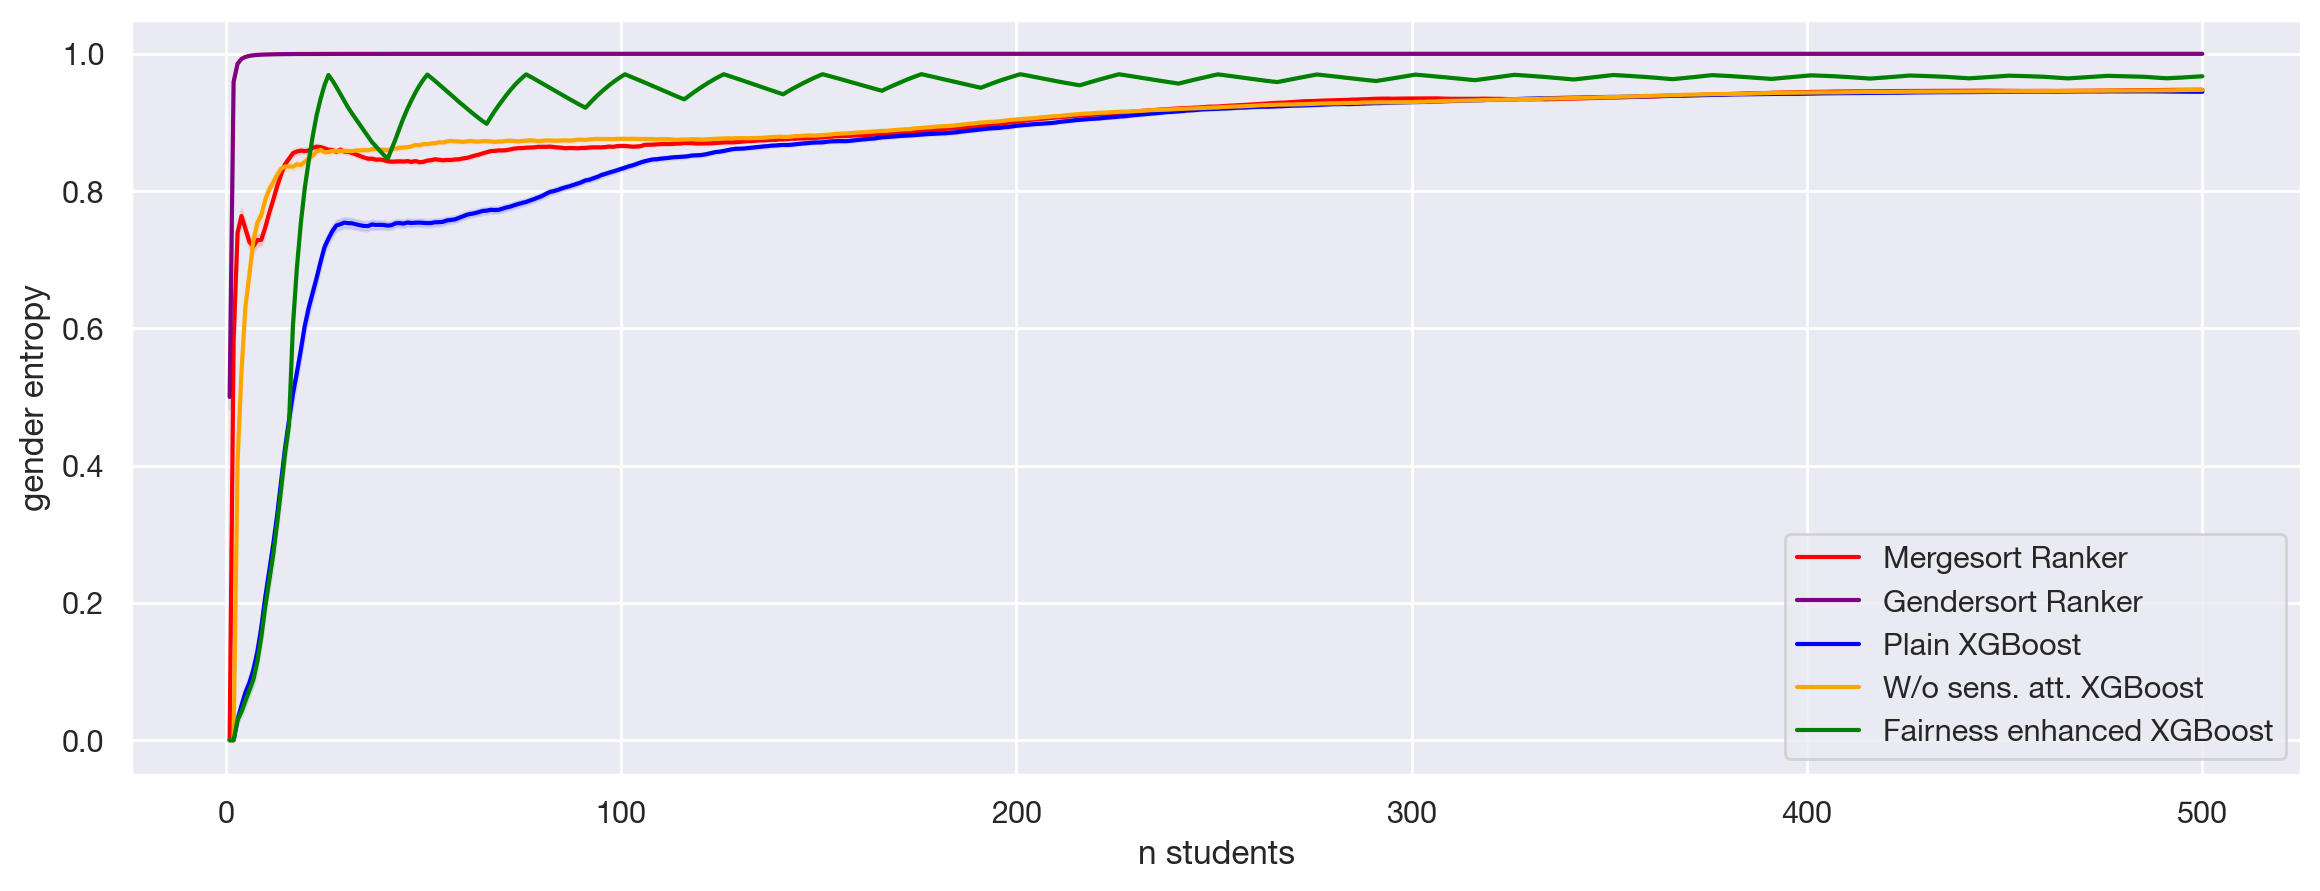

In [76]:
k=0
l=500


#Mergesort
sns.lineplot(data=df_sort_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="red", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_sort_BIG_mean[k:l], alpha=0.1, color="red")

#Gendersort
sns.lineplot(data=gender_df_BIG_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="purple", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=gender_df_BIG_mean[k:l], alpha=0.1, color="purple")

#Rankers
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="blue") #lw=0.2
plt.fill_between("n_students", "lower_std", "upper_std",data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], alpha=0.1, color="blue")

sns.lineplot(data=df_wo_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="orange", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_wo_ENTROPY_mean[k:l], alpha=0.1, color="orange")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")


plt.xlabel('n students')
plt.ylabel('gender entropy')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
# plt.title('Entropy of models - Gender, all rankers')
plt.legend(['Mergesort Ranker', 'Gendersort Ranker',"Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="lower right")

# plt.savefig('all_entropy.png')

plt.show()

### FAIR entropy: mean and CMA

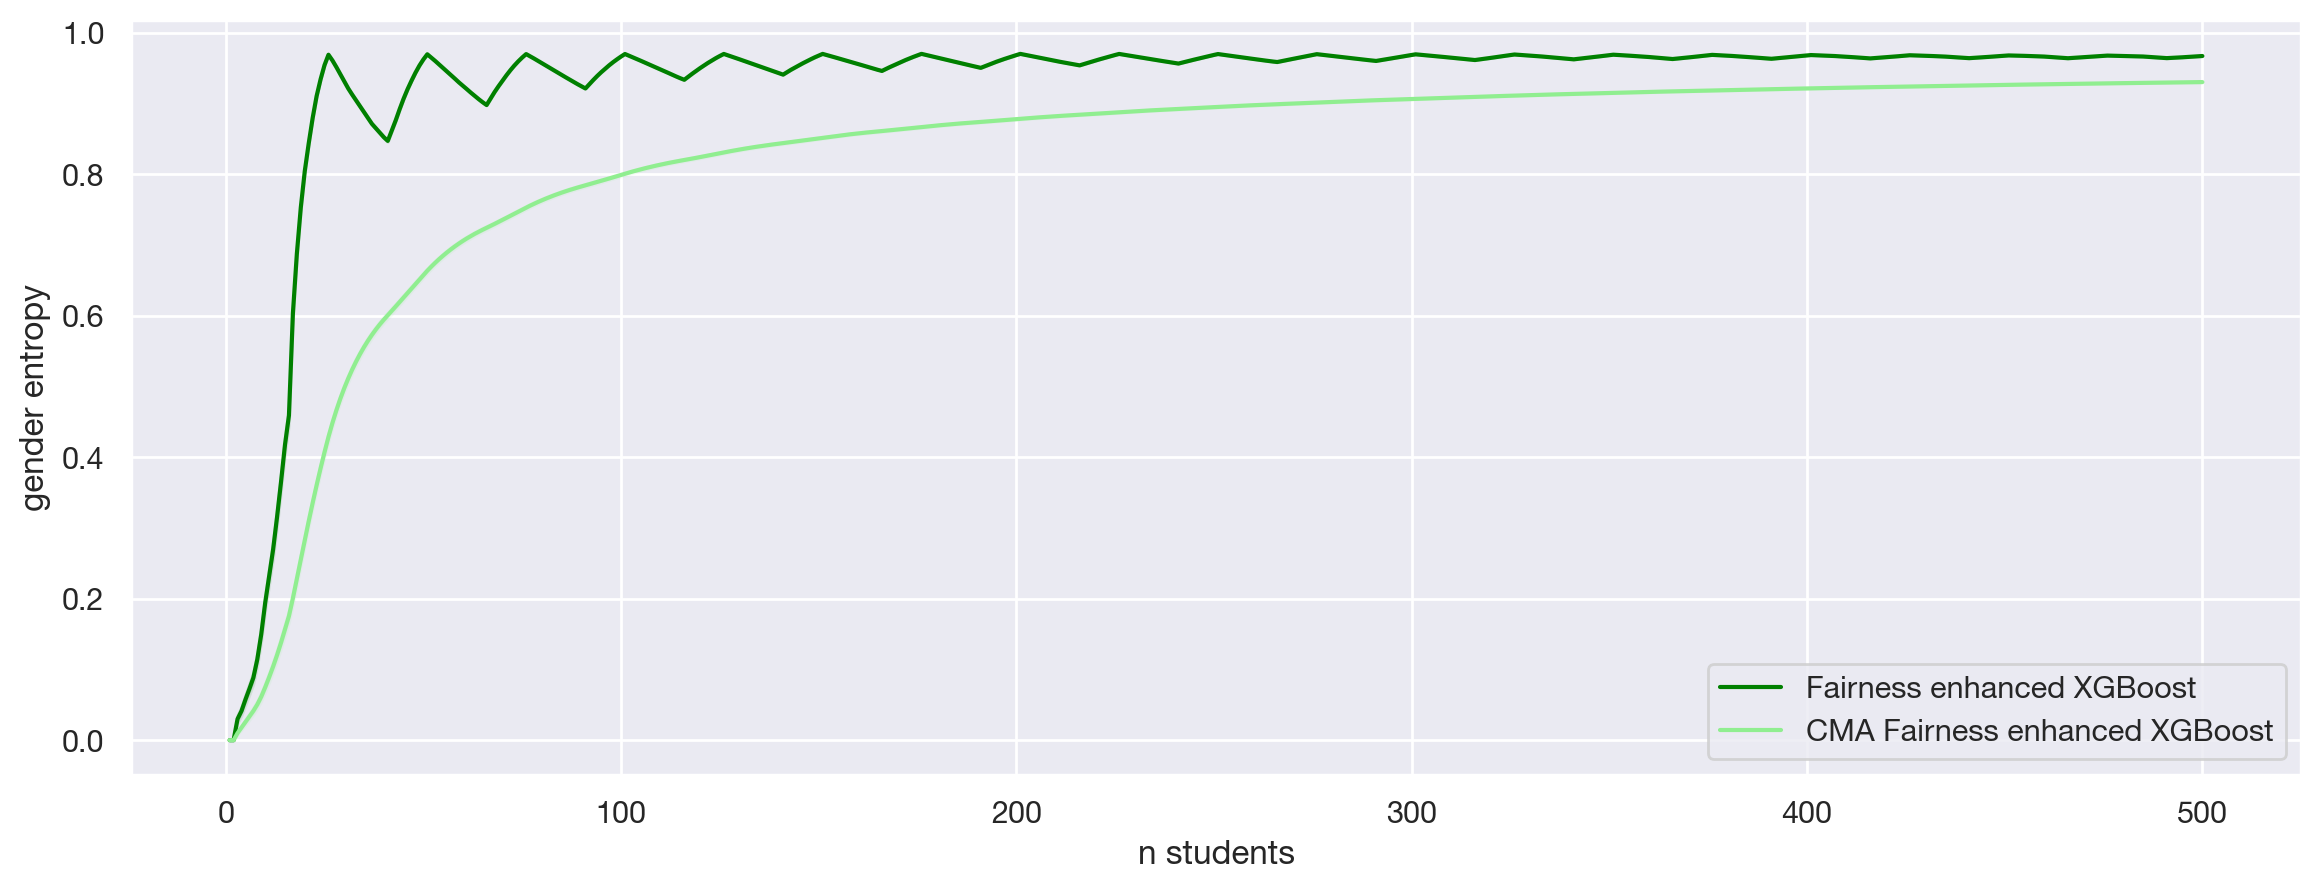

In [119]:
k=0
l=500


sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="CMA_gender_entropy",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_fair_ENTROPY_mean[k:l], alpha=0.1, color="lightgreen")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Fairness enhanced XGBoost", "CMA Fairness enhanced XGBoost"], loc ="lower right")
plt.show()

### All rankers with random

In [203]:
## Random entropy

# #Random generated dfs
pd.options.mode.chained_assignment = None 

df_use = df_for_random.copy()
df_use = df_use[["Unnamed: 0","COL_GRADE_AVG", "GENDER_bin", "HI_GRADE_AVG"]] #"STRATUM"

for j in range(1,2): #first make one random df that we can append the other random dfs to
    gen_state = random.seed(a=None) #random generator
    df_random1 = shuffle(df_use, random_state=gen_state) #shuffle the df with a random generator based on time
    df_random1["incr_col_mean"] = df_random1.COL_GRADE_AVG.expanding().mean()
    df_random1["n_students"] = range(1,len(df_random1)+1)
    for i in range(1000):
        gen_state = random.seed(a=None)
        df_random2 = shuffle(df_use, random_state=gen_state)
        df_random2["incr_col_mean"] = df_random2.COL_GRADE_AVG.expanding().mean()
        df_random2["n_students"] = range(1,len(df_random2)+1)
        df_random1 = df_random1.append(df_random2)

# # #The random df to use = df_random1


In [204]:
# #only take n students from index 1-500
indexs = np.arange(1,501)
df_random_use = df_random1.loc[df_random1['n_students'].isin(indexs)]
df_random_use = df_random_use.reset_index()


In [205]:
# DENNE VIRKER!!!!

random_value_counts_GENDER = []
i = 0
while i < 999:
    idx = 0
    while idx <= df_random_use.n_students.max():
        random_value_counts_GENDER.append(np.array([df_random_use["GENDER_bin"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

In [206]:
df_random_use["value_counts_col_GENDER"] = random_value_counts_GENDER

ValueError: Length of values (500499) does not match length of index (500500)

In [ ]:
#Entropy for each row

random_entropy_GENDER = []
for i in df_random_use.index:
    random_entropy_GENDER.append(-(df_random_use["value_counts_col_GENDER"][i]*np.log2(df_random_use["value_counts_col_GENDER"][i])).sum())    

In [ ]:
df_random_use["entropy_col_GENDER"] = random_entropy_GENDER

In [ ]:
df_random_use

In [152]:
#Mean gender entropy
df_random_BIG_mean =  df_random_BIG.groupby('INDEXES').mean()
df_random_BIG_mean["incr_col_entropy"] = df_random_BIG_mean['entropy_col_GENDER'].expanding().mean()


#SMA std entropy
df_random_BIG_std = df_random_BIG.groupby('INDEXES').std()/np.sqrt(200)
df_random_BIG_std["incr_col_entropy"] = df_random_BIG_std['entropy_col_GENDER'].expanding().mean()


#Adding standard error column for "incr_col_mean" and variables for plotting 200.
df_random_BIG_mean["incr_half_std"] = 0.5*df_random_BIG_std["entropy_col_GENDER"] #0.5 of std to plot on both sides of mean
df_random_BIG_mean["lower_std"] = df_random_BIG_mean["entropy_col_GENDER"] - df_random_BIG_mean["incr_half_std"]
df_random_BIG_mean["upper_std"] = df_random_BIG_mean["entropy_col_GENDER"] + df_random_BIG_mean["incr_half_std"]


#For cum
df_random_BIG_mean["incr_half_cum_std"] = 0.5*df_random_BIG_std["incr_col_entropy"] #0.5 of std to plot on both sides of mean
df_random_BIG_mean["lower_std_cum"] = df_random_BIG_mean["incr_col_entropy"] - df_random_BIG_mean["incr_half_cum_std"]
df_random_BIG_mean["upper_std_cum"] = df_random_BIG_mean["incr_col_entropy"] + df_random_BIG_mean["incr_half_cum_std"]



In [ ]:
# random entropy gender

# list of colors: https://matplotlib.org/stable/gallery/color/named_colors.html

#df_sort["n_students"] = range(len(df_sort))

sns.color_palette("deep")

# randomsort entropy of gender
sns.lineplot(data=df_random_use, x="n_students", y="entropy_col_GENDER", ci="sd", color="cornflowerblue")
plt.show()

In [ ]:

sns.lineplot(data=df_random_BIG_mean[k:l], x="INDEXES", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_BIG_mean[k:l], alpha=0.1, color="green")


ValueError: Could not interpret value `incr_col_entropy` for parameter `y`

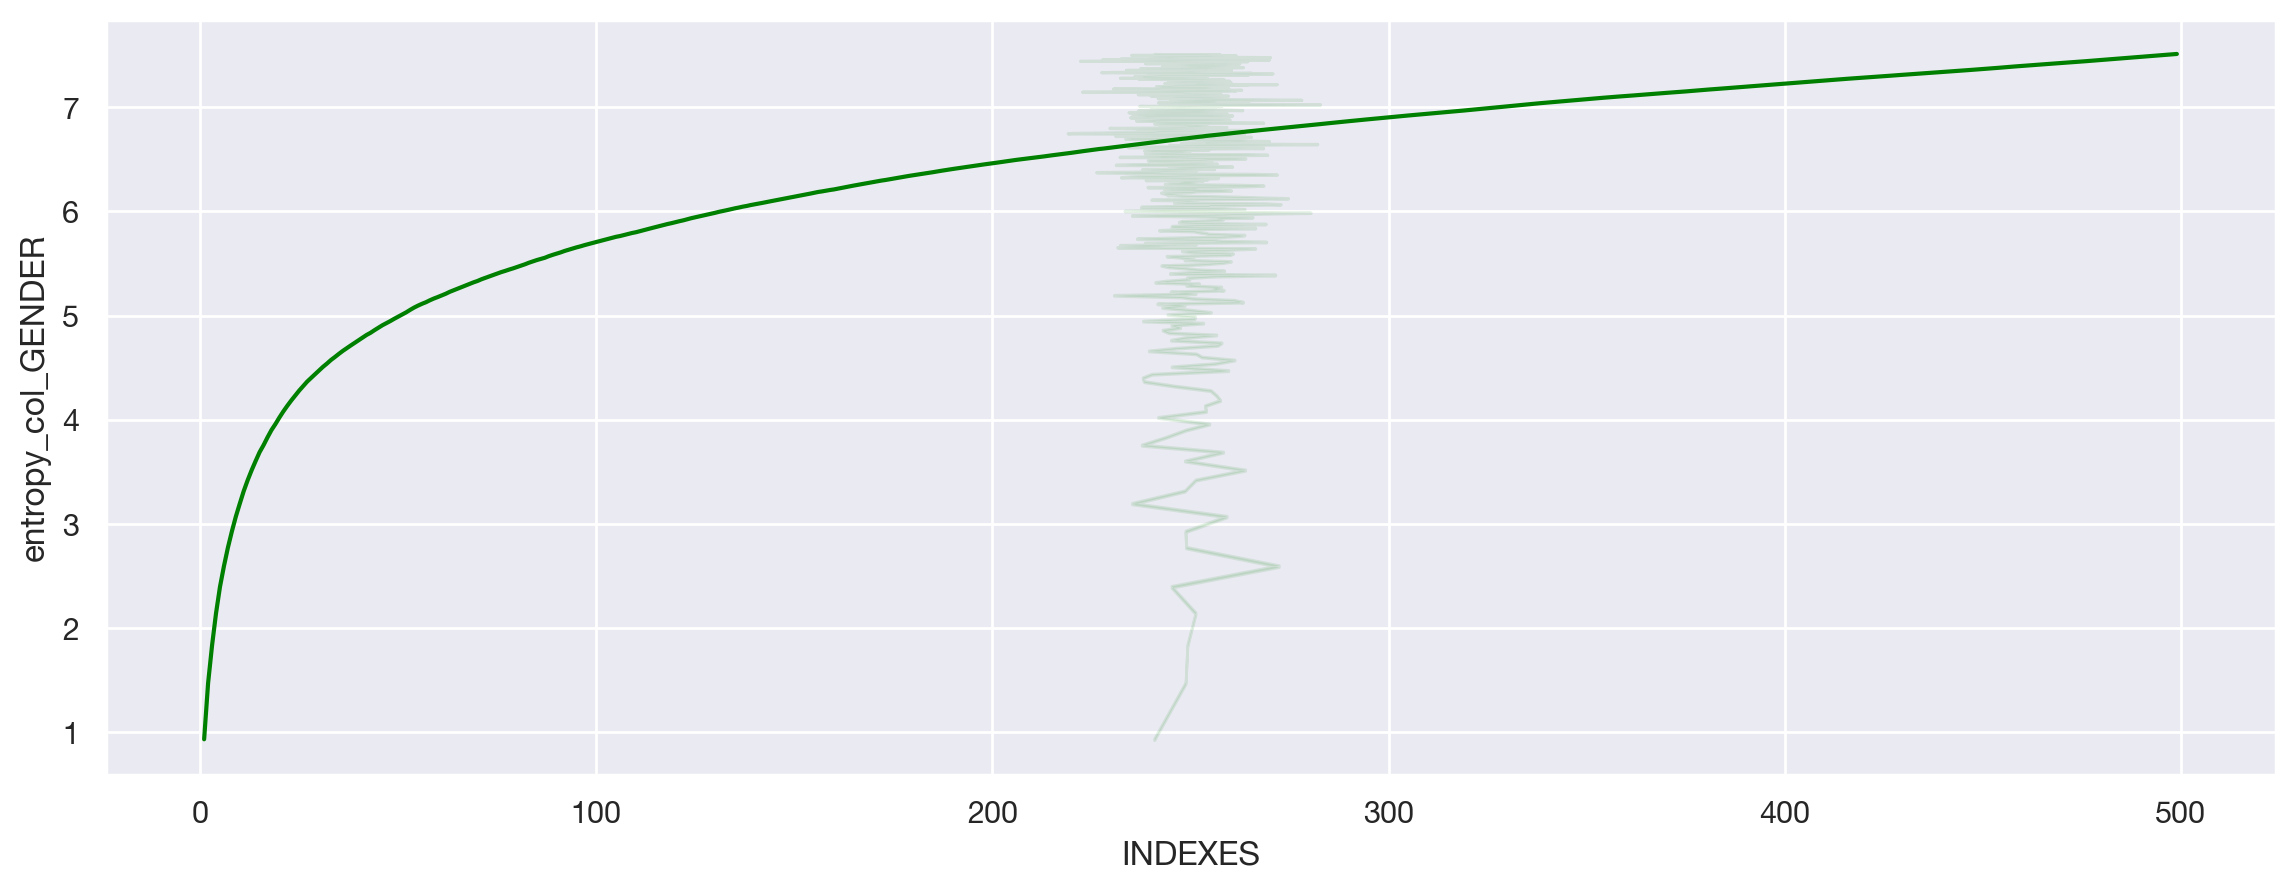

In [171]:
k=1
l=500


sns.lineplot(data=df_random_BIG_mean[k:l], x="INDEXES", y="entropy_col_GENDER",  color="green", ci="sd")
plt.fill_between("n_students", "lower_std", "upper_std",data=df_random_BIG_mean[k:l], alpha=0.1, color="green")

sns.lineplot(data=df_fair_ENTROPY_mean[k:l], x="n_students", y="incr_col_entropy",  color="lightgreen", ci="sd")
plt.fill_between("n_students", "lower_std_cum", "upper_std_cum",data=df_random_BIG_mean[k:l], alpha=0.1, color="green")


plt.xlabel('n students')
plt.ylabel('gender entropy')
plt.legend(["Random ranker", "CMA Random ranker"], loc ="lower right")
plt.show()